In [82]:
import sys
sys.path.append('../')

import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd
import jsonpickle

from particle_filter import particlefilter
from pmcmc import particlemcmc
from math_utils import nbinom_logpmf

In [83]:
pmcmc_output = np.load('../pmcmc_output/SIRS_rho_pmcmc_output.npz')

In [84]:
def SIRS_model(particles,observations,t,dt,model_params,rng):
    '''Definition of SEIR model as described in Calvetti's paper. Difference 
    is the use of Tau leaping to introduce stochasticity into the system and continuous log-normal OU process definition for beta.'''
    gamma,xi,sig,mu,rho,R = model_params

    lam = 1/100

    A = np.exp(-lam * dt)
    M = mu * (np.exp(-lam * dt) - 1)
    C = sig * np.sqrt(1 - np.exp(-2 * lam * dt))

    '''Tau leaping. Non estimated parameters are hard coded. '''

    for index in range(particles.shape[0]):

        new_I = rng.poisson((particles[index,3,t] * particles[index, 1, t]* particles[index, 0, t])/np.sum(particles[index,:,t]) * dt)
        new_S = rng.poisson((xi * particles[index,2,t]) * dt)
        new_R = rng.poisson((gamma * particles[index,1,t]) * dt)

        particles[index,0,t] = np.maximum(0.,particles[index,0,t] - new_I + new_S) #S
        particles[index,1,t] = np.maximum(0.,particles[index,1,t] + new_I - new_R) #I
        particles[index,2,t] = np.maximum(0.,particles[index,2,t] + new_R-new_S) #R

        particles[index,3,t] = np.exp(A * np.log(particles[index,3,t]) - M + C * rng.standard_normal())

        observations[index,0,t] = particles[index,1,t]

    return particles,observations

def SIRS_Obs(data_point, particle_observations, model_params):
    rho = model_params[4]
    r = 1/model_params[5]
    weights = nbinom_logpmf(x = data_point,p = r/(r + rho * (particle_observations[:,0] + 0.005)),n = np.array([r]))
    return weights

def SIRS_init(num_particles, model_dim, rng):
    particles_0 = np.zeros((num_particles,model_dim))
    particles_0[:,0] = 500
    I_init = rng.integers(1,5,size = (num_particles))
    particles_0[:,0] -= I_init
    particles_0[:,1] = I_init
    particles_0[:,3] = rng.uniform(0.,1., size = (num_particles,))
    

    return particles_0

In [85]:
data = pd.read_csv('../data_sets/ou_SIRS_data_reporting_rate.csv',index_col=False).to_numpy()

par = np.mean((pmcmc_output['accepted_params'][:,10_000:]),axis = 1)
T = 365
dt = 0.1
t_vec = np.arange(0,T,dt)

pf_params = {'num_particles':10_000, 
                      'dt':0.1,
                      'model':SIRS_model,
                      'observation_model':SIRS_Obs,
                      'model_dim':4,
                      'particle_initializer':SIRS_init,
                      }

output = particlefilter(data = data,
        model_params= par,
        pf_params = pf_params,
        rng = np.random.default_rng(1),
        req_jit=True
        )


 Log Likelihood : -1260.5552860608204
Root Mean Squared Error for the Data 22.08372317252426


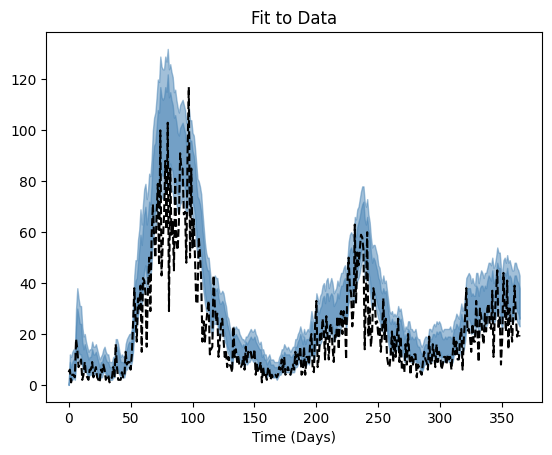

In [87]:
'''Plots using the Expectation of the parameters and running the filter. '''
print(f" Log Likelihood : {np.sum(output['Log_likelihood'])}")
print(f"Root Mean Squared Error for the Data {np.sqrt(np.mean((data - np.mean(output['particle_observations'][:,0,:]))**2))}")


plt.title("Fit to Data")
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data.T,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,2.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,12.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.show()

In [ ]:
def IS(alpha: float, predL: float, predU: float):
    """
    Calculates Interval Score. Helper function for WIS.

    Args:
        alpha: 1 - the difference between quantile marks.
        predL: Predicted value for lower quantile.
        predU: Predicted value for upper quantile.

    Returns:
        Interval Score function.
    """
    return (
        lambda y: (predU - predL)
        + 2 / alpha * (y < predL) * (predL - y)
        + 2 / alpha * (y > predU) * (y - predU)
    )


In [ ]:
def WIS(y_obs: float, qtlMark: list[float], predQTL: list[float]) -> float:
    """
    Calculates a Weighted Interval Score based on this paper:
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7880475/

    Args:
        y_obs: Observed hospitalization data points.
        qtlMark: The quantile marks used in forecast data file.
        predQTL: Predicted values for each quantile.

    Returns:
        WIS score.
    """
    if len(qtlMark) % 2 == 0:
        raise ValueError(
            "Check the quantile marks: either no median defined, or not in symmetric central QTL form."
        )

    NcentralizedQT = (len(qtlMark) - 1) // 2 + 1
    alpha_list = [1 - (qtlMark[-1 - i] - qtlMark[i]) for i in range(NcentralizedQT)]
    weight_list = [alpha / 2 for alpha in alpha_list]

    output = abs(y_obs - predQTL[NcentralizedQT - 1]) / 2
    for i in range(NcentralizedQT - 1):
        output += weight_list[i] * IS(alpha_list[i], predQTL[i], predQTL[-1 - i])(y_obs)

    return output / (NcentralizedQT - 0.5)

In [104]:
qtl_list = [0.25,0.50,0.75]
pred_qtl = np.quantile(output['particle_observations'][:,0,:].T,qtl_list,axis = 1)

WIS_score = np.sum(WIS(data,qtl_list,pred_qtl))

print(WIS_score)


ValueError: operands could not be broadcast together with shapes (1,365) (3,) 